Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0      

C:\Users\Murali\AppData\Local\Temp\ipykernel_22368\2694779895.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
C:\Users\Murali\AppData\Local\Temp\ipykernel_22368\2694779895.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

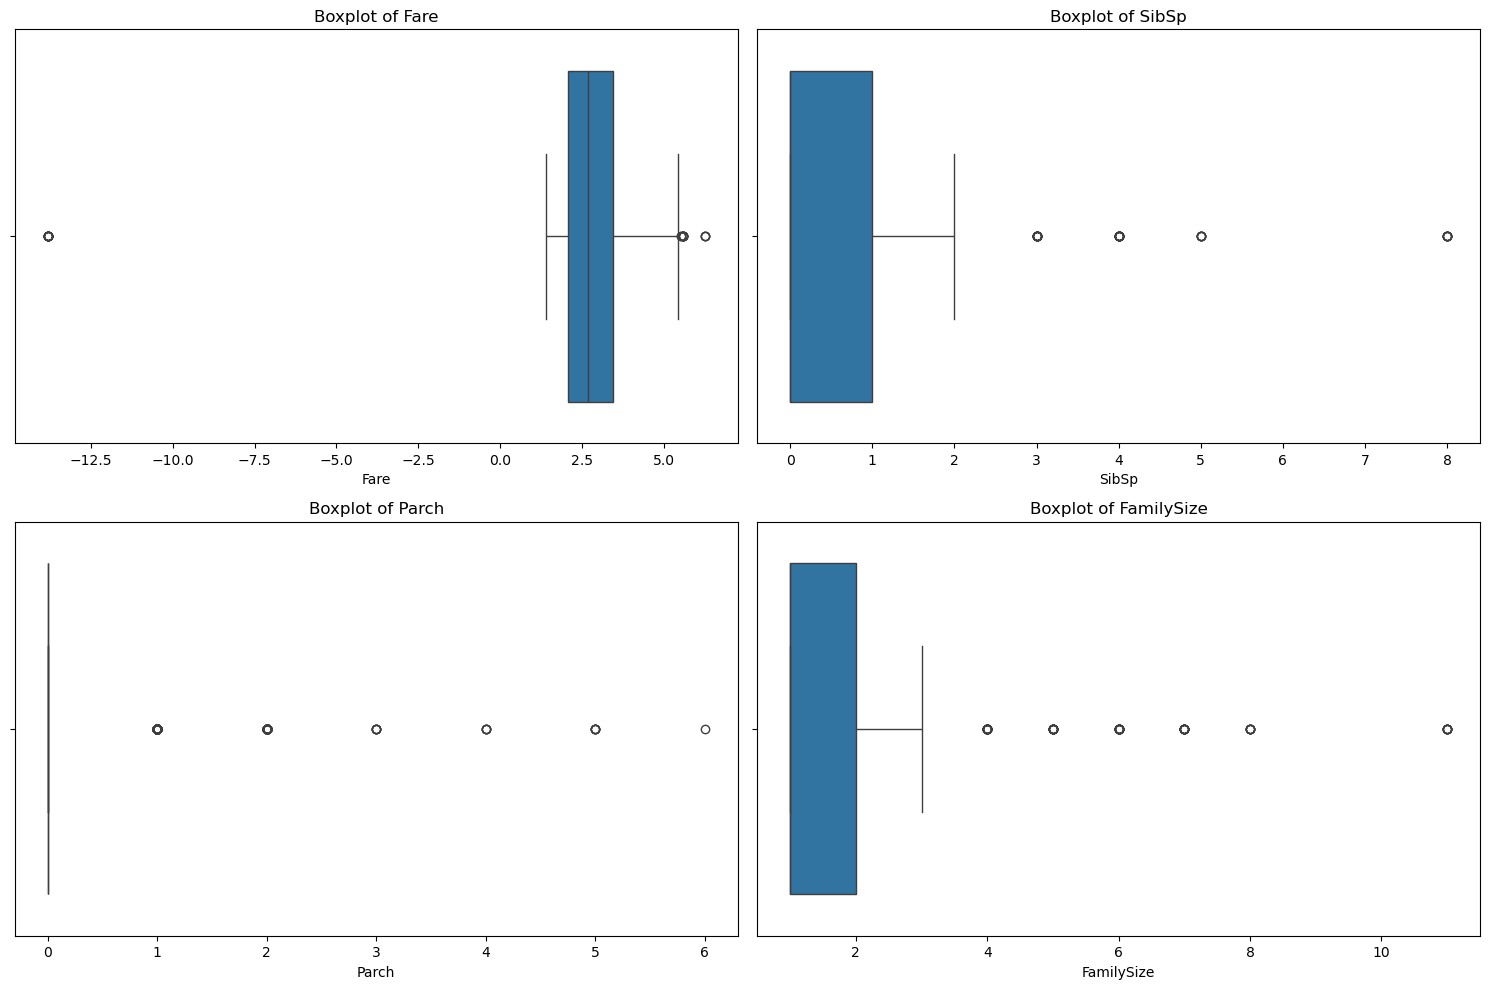


Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, 0 to 890
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             865 non-null    int64  
 1   Sex                865 non-null    int32  
 2   SibSp              865 non-null    float64
 3   Parch              865 non-null    float64
 4   Fare               865 non-null    float64
 5   Embarked           865 non-null    int32  
 6   FamilySize         865 non-null    float64
 7   IsAlone            865 non-null    int32  
 8   Title_Billiard     865 non-null    bool   
 9   Title_Carlo        865 non-null    bool   
 10  Title_Cruyssen     865 non-null    bool   
 11  Title_Gordon       865 non-null    bool   
 12  Title_Impe         865 non-null    bool   
 13  Title_Master       865 non-null    bool   
 14  Title_Melkebeke    865 non-null    bool   
 15  Title_Messemaeker  865 non-null    bool   
 16  Title_Miss

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('Titanic-Dataset.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe(include='all'))
print("\nMissing Values:")
print(df.isnull().sum())

# FIXED: Age - Fill missing values with median age grouped by Pclass and Sex
# Using transform instead of apply to maintain proper index alignment
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Cabin - Too many missing values, we'll drop this column
df.drop('Cabin', axis=1, inplace=True)

# Embarked - Only 2 missing, fill with most common value
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Fare - One missing value in test set, fill with median
df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Create new features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

# Extract titles from names - FIXED the regex pattern
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Drop unnecessary columns
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# Label encoding for ordinal categories
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])  # Male:1, Female:0
df['Embarked'] = label_encoder.fit_transform(df['Embarked'])

# One-hot encoding for nominal categories
df = pd.get_dummies(df, columns=['Title'], prefix=['Title'])

# Convert boolean to int
df['IsAlone'] = df['IsAlone'].astype(int)

# Log transform Fare to reduce skewness (adding small constant to avoid log(0))
df['Fare'] = df['Fare'].map(lambda x: np.log(x + 1e-6))

# Bin age into categories
df['AgeBin'] = pd.cut(df['Age'].astype(int), 5, labels=False)

# Drop original Age column
df.drop('Age', axis=1, inplace=True)

# Visualize outliers for numerical features
numerical_features = ['Fare', 'SibSp', 'Parch', 'FamilySize']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

# Remove outliers from Fare (using IQR method)
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Fare'] < (Q1 - 1.5 * IQR)) | (df['Fare'] > (Q3 + 1.5 * IQR)))]

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['Fare', 'SibSp', 'Parch', 'FamilySize']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Normalize other numerical features if needed
minmax_scaler = MinMaxScaler()
df[['AgeBin']] = minmax_scaler.fit_transform(df[['AgeBin']])

# Separate features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

# Display final dataset info
print("\nFinal Dataset Info:")
print(X.info())
print("\nFirst 5 rows of processed data:")
print(X.head())